## Data exploration and baseline model

### Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

In [2]:
# Combined bill text / discriminatory label datasets
df = pd.read_csv("data/ML_text_data.csv")
df

doc_id                                               text   
0     2765271    Enrolled HB  LAWS OF ALASKA            Sourc...  \
1     2776866    HBa -- HB    New Text Underlined [DELETED TE...   
2     2732779    HBa -- HB    New Text Underlined [DELETED TE...   
3     2693088    SBA -- SB    New Text Underlined [DELETED TE...   
4     2767132    SBA -- SB    New Text Underlined [DELETED TE...   
...       ...                                                ...   
2655  2758370  As Amended by Senate Committee As Amended by H...   
2656  2759820  FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...   
2657  2742094  HOUSE BILL No.  AN ACT concerning  education; ...   
2658  2626885  Stricken language would be deleted from and un...   
2659  2717469      HB HFLR  Page   BOLD FACE  denotes Committ...   

      discriminatory  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
2655               1  
2656               1  
2657               1  
2658               1  
2659               1  

[2660 rows x 3 columns]

In [3]:
# Drop bills with no text
df = df[df['text'].notna()]
df

doc_id                                               text   
0     2765271    Enrolled HB  LAWS OF ALASKA            Sourc...  \
1     2776866    HBa -- HB    New Text Underlined [DELETED TE...   
2     2732779    HBa -- HB    New Text Underlined [DELETED TE...   
3     2693088    SBA -- SB    New Text Underlined [DELETED TE...   
4     2767132    SBA -- SB    New Text Underlined [DELETED TE...   
...       ...                                                ...   
2655  2758370  As Amended by Senate Committee As Amended by H...   
2656  2759820  FIRST REGULAR SESSION HOUSE COMMITTEE SUBSTITU...   
2657  2742094  HOUSE BILL No.  AN ACT concerning  education; ...   
2658  2626885  Stricken language would be deleted from and un...   
2659  2717469      HB HFLR  Page   BOLD FACE  denotes Committ...   

      discriminatory  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
2655               1  
2656               1  
2657               1  
2658               1  
2659               1  

[2660 rows x 3 columns]

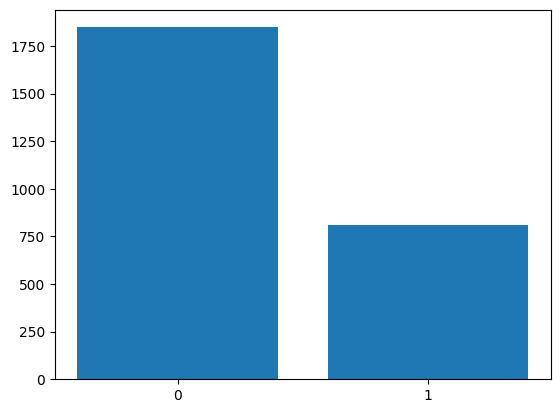

In [6]:
counts = df.value_counts('discriminatory')
counts_df = pd.DataFrame(counts)
counts_df.reset_index(inplace=True)
counts_df['discriminatory'] = counts_df['discriminatory'].astype('str')
_, plot = plt.bar(counts_df['discriminatory'], counts_df['count'])
plot

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hemmerly/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from nltk.corpus import stopwords

In [31]:
stop_words = set(stopwords.words('english'))

In [30]:
# Bill text cleanup function
def clean_text(text):
    text = str(text)
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    text = text.strip().lower().split(" ")
    text = [w for w in text if w not in stop_words]
    return text

In [32]:
# Try tokenizing bill texts; identify short/messy texts
tokenized_texts = []
min_len = float('inf')
max_len = 0
lengths = []
num_weird_bills = 0

for text in df["text"]:
    text = clean_text(text)
    tokenized_texts.append(text)
    num_tokens = len(text)
    lengths.append(num_tokens)
    if num_tokens > max_len:
        max_len = num_tokens
    if num_tokens < min_len:
        min_len = num_tokens
    if num_tokens < 100:
        # print short bill texts for inspection
        print(text)
        num_weird_bills += 1

# print key info
print("min length:", min_len, ", max length:", max_len)
print("num bills:", len(tokenized_texts), ", num weird bills:", num_weird_bills)

['sba', '--', 'sb', '-ls\\a', 'senate', 'bill', 'no.', 'legislature', 'state', 'alaska', 'thirty-third', 'legislature', '-', 'first', 'session', 'senator', 'gray-jackson', 'introduced:', '//', 'referred:', 'prefiled', 'bill', 'act', 'entitled', '"an', 'act', 'establishing', 'month', 'october', 'filipino', 'american', 'history', 'month."', 'enacted', 'legislature', 'state', 'alaska:', '*', 'section', '.', '.', 'amended', 'adding', 'new', 'section', 'read:', 'sec.', '...', 'filipino', 'american', 'history', 'month.', 'month', 'october', 'year', 'established', 'filipino', 'american', 'history', 'month.', 'fi', 'lipino', 'american', 'history', 'month', 'may', 'observed', 'schools,', 'community', 'groups,', 'public', 'private', 'agencies', 'individuals', 'appropriate', 'activities', 'honor', 'recognize', 'contributions', 'filipino', 'americans', 'made', 'history', 'f', 'h', 'e', 'e', 'n', 'h', 'e', 'united', 'states.']
['hba', '--', 'hb', '-ls\\a', 'house', 'bill', 'no.', 'legislature', 'st

In [33]:
tokenized_texts_short = [text for text in tokenized_texts if len(text) < 10000]

In [34]:
lengths_short = [len(text) for text in tokenized_texts_short]

In [35]:
len(tokenized_texts_short)


2611

<BarContainer object of 20 artists>

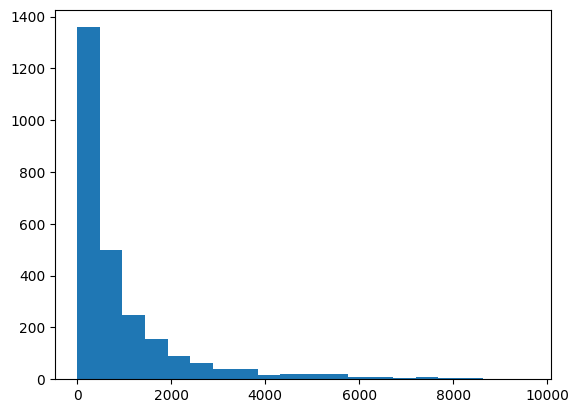

In [36]:
# Get a sense of how many tokens are in most bill texts
_, _, plot = plt.hist(lengths_short, bins=20)
plot

### Data prep for CBOW model

In [37]:
# Create vocab from bill text
vocab = build_vocab_from_iterator(tokenized_texts, specials=["<unk>"], min_freq = 10)

In [49]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["sex"])
print(vocab["transgender"])

21274
<unk>
person
56
138
103
4281


In [50]:
# Turn our labels and cleaned-up text into a coherent dataset (list of tuples)
data = []
for label, tokens in zip(df["discriminatory"], tokenized_texts):
    #single_string = ""
    #for token in text:
    #    single_string = single_string + token + " "
    data.append((label, tokens))

data = [(label, tokens) for (label, tokens) in data if len(tokens) < 10000 and len(tokens) > 100] 

# Iterator version (not sure if needed)
data_iter = iter(data)
[next(data_iter)]

[(0,
  ['enrolled',
   'hb',
   'laws',
   'alaska',
   'source',
   'chapter',
   'no.',
   'cshb',
   '(fin)',
   '_______',
   'act',
   'making',
   'supplemental',
   'appropriati',
   'ons',
   'appropriations;',
   'king',
   'appropriations',
   'art.',
   'ix,',
   'sec.',
   '(c),',
   'constitution',
   'state',
   'alaska,',
   'constitutional',
   'budget',
   'reserve',
   'fund;',
   'providing',
   'effective',
   'date.',
   '_______________',
   'enacted',
   'legislature',
   'state',
   'alaska:',
   'act',
   'follows',
   'page',
   '--',
   'enrolled',
   'hb',
   'act',
   'making',
   'supplemental',
   'appropriati',
   'ons',
   'appropriations;',
   'king',
   'appropriations',
   'art.',
   'ix,',
   'sec.',
   '(c),',
   'constitution',
   'state',
   'alaska,',
   'constitutional',
   'budget',
   'reserve',
   'fund;',
   'providing',
   'effective',
   'date.',
   '_______________',
   '(section',
   'act',
   'begins',
   'page',
   ')',
   'cshb',
   

In [51]:
# Turn our data into custom torch Dataset
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.vocab = build_vocab_from_iterator(
            tokenized_texts, specials=["<unk>"], min_freq = 10)
        self.vocab.set_default_index(self.vocab['<unk>'])

    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        label, tokenized_text = self.data[idx]
        #return label, tokenized_texts
        tokenized_texts_idxs = self.vocab.lookup_indices(tokenized_text)
        print(torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))
        return (torch.LongTensor([label]), torch.LongTensor(tokenized_texts_idxs))    

In [52]:
dataset = CustomDataset(data)

In [43]:
# GloVe
# Change dir!
VECTOR_CACHE_DIR = "CAPP/Adv_ML/.vector_cache"
glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

CAPP/Adv_ML/.vector_cache/glove.6B.zip: 862MB [05:29, 2.61MB/s]                               
100%|█████████▉| 399999/400000 [01:28<00:00, 4533.62it/s]


In [56]:
# Custom collate function for dataloader
def collate_into_cbow(batch):
    size = len(batch)
    lt = torch.zeros(size,)
    tt = torch.zeros(size, 300)

    for i, (label, token_list) in enumerate(batch):
        # create label tensor
        lt[i] = int(label)

        # create cbow using glove
        all_embeddings = glove.get_vecs_by_tokens([vocab.lookup_token(x) for x in token_list])
        #all_embeddings = glove.get_vecs_by_tokens(token_list)
        tt[i] = torch.mean(all_embeddings, dim = 0)
    
    lt = lt.type(torch.LongTensor)

    return (lt, tt)

In [57]:
# Create dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, 
                        collate_fn=collate_into_cbow)

In [69]:
# check dataloader
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt.shape, tt.shape)
    if idx == 4: 
        break

tensor([0]) tensor([  549,   101,   146,  2841,  1227,    27,    65,  9088, 13410,  8274,
           25,   564,  1255,     0,  4557, 12237,  8640,   583,  8289, 11114,
           81,  1866,   837,     6, 14467,  1783,   532,  1403,  3007,   143,
          151,  1207,  3584,   162,   142,     6,  7857,    25,  1427,    58,
           34,   549,   101,    25,   564,  1255,     0,  4557, 12237,  8640,
          583,  8289, 11114,    81,  1866,   837,     6, 14467,  1783,   532,
         1403,  3007,   143,   151,  1207,  3584,  5980,    25,  4023,    58,
          260,  9088,     0,    81,     7,     7,   419,     5,     1,    61,
          300,  1240,   359,  1223,    13,     9,    36,   268,    79,    45,
          532,  1095,   359,   532,   398,  1227,   740,  2279,   192,    47,
          115,  3997,    79,    45,   506,   219,     2,   510,   266,     2,
            2,  3885,   247,   132, 10329,   472,   472,   155,   472,   155,
          178,   114,    47,   178,    47,   155,   

In [59]:
# check dataloader cont.
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt, tt)
    if idx == 2: 
        break

tensor([0]) tensor([  549,   101,   146,  2841,  1227,    27,    65,  9088, 13410,  8274,
           25,   564,  1255,     0,  4557, 12237,  8640,   583,  8289, 11114,
           81,  1866,   837,     6, 14467,  1783,   532,  1403,  3007,   143,
          151,  1207,  3584,   162,   142,     6,  7857,    25,  1427,    58,
           34,   549,   101,    25,   564,  1255,     0,  4557, 12237,  8640,
          583,  8289, 11114,    81,  1866,   837,     6, 14467,  1783,   532,
         1403,  3007,   143,   151,  1207,  3584,  5980,    25,  4023,    58,
          260,  9088,     0,    81,     7,     7,   419,     5,     1,    61,
          300,  1240,   359,  1223,    13,     9,    36,   268,    79,    45,
          532,  1095,   359,   532,   398,  1227,   740,  2279,   192,    47,
          115,  3997,    79,    45,   506,   219,     2,   510,   266,     2,
            2,  3885,   247,   132, 10329,   472,   472,   155,   472,   155,
          178,   114,    47,   178,    47,   155,   

In [60]:
# check dataloader cont.
check = 0
for idx, (lt, tt) in enumerate(dataloader):
    for val in lt:
        if val == 1:
            check += 1
print(check)
print(sum(df["discriminatory"]))

tensor([0]) tensor([  549,   101,   146,  2841,  1227,    27,    65,  9088, 13410,  8274,
           25,   564,  1255,     0,  4557, 12237,  8640,   583,  8289, 11114,
           81,  1866,   837,     6, 14467,  1783,   532,  1403,  3007,   143,
          151,  1207,  3584,   162,   142,     6,  7857,    25,  1427,    58,
           34,   549,   101,    25,   564,  1255,     0,  4557, 12237,  8640,
          583,  8289, 11114,    81,  1866,   837,     6, 14467,  1783,   532,
         1403,  3007,   143,   151,  1207,  3584,  5980,    25,  4023,    58,
          260,  9088,     0,    81,     7,     7,   419,     5,     1,    61,
          300,  1240,   359,  1223,    13,     9,    36,   268,    79,    45,
          532,  1095,   359,   532,   398,  1227,   740,  2279,   192,    47,
          115,  3997,    79,    45,   506,   219,     2,   510,   266,     2,
            2,  3885,   247,   132, 10329,   472,   472,   155,   472,   155,
          178,   114,    47,   178,    47,   155,   

### CBOW model

In [61]:
# Model class
class CBoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        # nn.Module init
        super(CBoWClassifier, self).__init__()
        # linear layer: affine map given input dim, output dim
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, cbow_vec):
        # pass through linear layer, then softmax
        linear_output = self.linear(cbow_vec)
        output = F.log_softmax(linear_output, dim = 1)
        return output

In [62]:
# Training function
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 20

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [63]:
# Accuracy function

def get_accuracy(dataloader):
    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_examples = 0

        for _, (label, text) in enumerate(dataloader):
            output = model(text)
            print("output", output)
            pred_label = output.argmax(1)
            print("pred_label", pred_label)
            if sum(pred_label) > 0:
                print(f"PREDICTED DISCRIMINATORY!")
            num_examples = len(label)
            print("label", label)
            num_correct = sum(torch.eq(pred_label, label))

            total_correct += num_correct
            total_examples += num_examples

    return total_correct/total_examples

In [64]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

1899 train 237 validation 238 testing


In [66]:
# Set parameters, create model instance, create split dataloaders
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(glove.get_vecs_by_tokens("test"))
model = CBoWClassifier(num_labels, vocab_size)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)

In [68]:
EPOCHS = 3 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=.0001)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

TypeError: lookup_token(): incompatible function arguments. The following argument types are supported:
    1. (self: torchtext._torchtext.Vocab, arg0: int) -> str

Invoked with: <torchtext._torchtext.Vocab object at 0x7f0f754abf70>, 'nd'

### If you follow the "open in a text editor" link for the above output and ctrl-F for my hopeful print statement "PREDICTED DISCRIMINATORY!" you can double-check whether or not the model literally ever predicted a 1 

In [839]:
# check class 1 ratio as reference point
    # for VALIDATION dataset
# (you'd be right this % of the time if you always guessed non-discriminatory)
total_count = 0
count_1s = 0
for bill in valid_data:
    count_1s += bill[0]
    total_count += 1
1 - count_1s / total_count

0.8317307692307692

### So the model (each time I ran it) is predicting 0 every time, thus the validation accuracy plotted above is a straight line at exactly the true percent of 0s in the validation dataset

In [838]:
get_accuracy(test_dataloader)

output tensor([[-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567]])
pred_label tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
output tensor([[-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.2117, -1.6567],
        [-0.21

tensor(0.8182)

In [840]:
# check class 1 ratio as reference point
    # for TEST dataset
# (you'd be right this % of the time if you always guessed non-discriminatory)
total_count = 0
count_1s = 0
for bill in test_data:
    count_1s += bill[0]
    total_count += 1
1 - count_1s / total_count

0.8181818181818181

### and same issue with the test data and test accuracy above

### Things to do:
- explore whether there's more initial data cleaning to be done (bill texts are still rough around the edges, a small few are totally messed up)
- produce some simple analytics on the dataset for the final report
- ** research class imbalance (ask TA(s) as well?)
- and the big next step: develop 2 (?) fancier models